# Data Workflow Lab 2

Proceed with your analysis of the Project 3 data set. You may need to compute new columns as you proceed. Fit one or more linear models to the data, investigate model fits and outliers, use regularization when appropriate.

### Learning objectives
- Perform exploratory analysis
- Generate correlation matrix of the features
- Generate linear regression models
- Evaluate model fit

If appropriate for your models and featuers:
- Use [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html) to pick the best features
- Try different regularization options

In [1]:
% matplotlib inline

from collections import defaultdict
import datetime

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = 5, 5
import seaborn as sns

import numpy as np
import pandas as pd
from sklearn import linear_model, preprocessing, metrics
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict

### Cleaning

In [161]:
# Load the data from the previous lab
# If you changed the name you'll need to edit the next line
sales = pd.read_csv("sales_cleaned.csv")

# Convert dates
sales["First Date"] = pd.to_datetime(sales["First Date"], format = "%Y-%m-%d")
sales["Last Date"] = pd.to_datetime(sales["Last Date"], format = "%Y-%m-%d")
sales = sales.rename(columns = {"Sale sum ($)": "2015 Total sales ($)", "Sale mean ($)": "2015 Mean sales ($)", "Mean Price per L": "2015 Mean price per liter ($)"})

sales.head()

,Unnamed: 0,Store Number,City,Margin mean,Zipcode,2015 Total sales ($),2015 Mean sales ($),Mean Price per L,2015 Total Volume Sold (Liters),2015 Mean Volume Sold (Liters),County number,2015 Sales Q1,2016 Sales Q1,First Date,Last Date
0,0,2106,CEDAR FALLS,92.665779,50613,146038.70,277.640114,17.844997,9719.85,18.478802,7,39287.29,30478.75,2015-01-08,2016-03-31
1,1,2113,GOWRIE,21.149932,50543,9310.22,63.334830,18.507700,659.85,4.488776,94,2833.25,2065.90,2015-01-07,2016-03-23
2,2,2130,WATERLOO,95.215652,50703,111583.91,285.380844,16.817589,6879.37,17.594297,7,24272.57,27856.11,2015-01-08,2016-03-31
3,3,2152,ROCKWELL,18.351277,50469,7721.08,54.759433,13.020765,633.37,4.491986,17,2003.46,904.66,2015-01-08,2016-02-25
4,4,2178,WAUKON,34.454430,52172,24324.18,102.633671,16.053844,1917.12,8.089114,3,5856.41,5588.50,2015-01-07,2016-03-30


In [157]:
## TEST ONLY
sales["County number"].unique().shape

(99,)

In [35]:
# Check which columns have NaN, and deal with them
sales.columns[pd.isnull(sales).any()].tolist()

['2016 Sales Q1']

In [36]:
# Drop NaN
sales_clean = sales.dropna()

## Exploratory Analysis
Make some plots, look at correlations, etc.

In [37]:
# Compute correlations
sales_clean.corr()

,Unnamed: 0,Store Number,Margin mean,2015 Total sales ($),2015 Mean sales ($),Mean Price per L,2015 Total Volume Sold (Liters),2015 Mean Volume Sold (Liters),County number,2015 Sales Q1,2016 Sales Q1
Unnamed: 0,1.000000,0.936957,-0.086396,-0.323195,-0.086127,0.058226,-0.359733,-0.111916,-0.008113,-0.311475,-0.298326
Store Number,0.936957,1.000000,-0.062352,-0.376246,-0.062249,0.004937,-0.412657,-0.074192,-0.008096,-0.360313,-0.354313
Margin mean,-0.086396,-0.062352,1.000000,0.446288,0.999975,0.120684,0.443491,0.936768,0.007377,0.419517,0.021345
2015 Total sales ($),-0.323195,-0.376246,0.446288,1.000000,0.446959,0.170287,0.992454,0.416107,0.044827,0.983786,0.149051
2015 Mean sales ($),-0.086127,-0.062249,0.999975,0.446959,1.000000,0.122172,0.443910,0.935613,0.007742,0.420029,0.021464
Mean Price per L,0.058226,0.004937,0.120684,0.170287,0.122172,1.000000,0.130079,-0.083952,0.100787,0.166982,-0.017654
2015 Total Volume Sold (Liters),-0.359733,-0.412657,0.443491,0.992454,0.443910,0.130079,1.000000,0.439668,0.036811,0.975140,0.166283
2015 Mean Volume Sold (Liters),-0.111916,-0.074192,0.936768,0.416107,0.935613,-0.083952,0.439668,1.000000,-0.014389,0.393769,0.026788
County number,-0.008113,-0.008096,0.007377,0.044827,0.007742,0.100787,0.036811,-0.014389,1.000000,0.048668,0.001704
2015 Sales Q1,-0.311475,-0.360313,0.419517,0.983786,0.420029,0.166982,0.975140,0.393769,0.048668,1.000000,0.152734


In [ ]:
# Perform some exploratory analysis, make a few plots

#### Total 2015 sales vs Total 2015 Q1 sales (all in dollars)
<img src="TotalsalesbyQ1.png" width=500 height=300>

#### Total 2015 sales (in dollars) vs Total 2015 volume sold (in liters)
<img src="Totalsalesbyvol.png" width=500 height=300>

#### Total 2015 sales vs Average margin per transaction (all in dollars)
<img src="Totalsalesbymargin.png" width=500 height=300>

### Model1: LR with CV, with only 2015 Q1 sales as predictor

#### 1.1: Data preprocessing

In [38]:
# Split first
X_train, X_test, y_train, y_test = train_test_split(sales_clean["2015 Sales Q1"], 
                                                    sales_clean["2015 Total sales ($)"],
                                                    test_size = 0.4)

In [39]:
# Training set variables standardize
Xs_train = preprocessing.scale(X_train)
ys_train = y_train
Xs_train = Xs_train.reshape(-1,1)
print(Xs_train.shape)

(685, 1)


#### 1.2: Model building

In [159]:
lm1 = linear_model.LinearRegression()
model = lm1.fit(Xs_train, ys_train)
pred_model = lm1.predict(Xs_train)

#### 1.3: Model metrics

In [160]:
# Cross-validation
scores = cross_val_score(lm1, Xs_train, ys_train, cv = 6)
predcv = cross_val_predict(lm1, Xs_train, ys_train, cv = 6)
print(scores)

#plt.scatter(Xs_train, predcv)
#plt.xlim(0,5)
#plt.ylim(0,200000)
#plt.show()

R2_model = metrics.r2_score(ys_train, pred_model)
R2_cv_scores = np.mean(scores)
rmse_model = (metrics.mean_squared_error(ys_train, pred_model))**0.5
rmse_cv = (metrics.mean_squared_error(ys_train, predcv))**0.5

print("R2_model_train: {}, R2_cv: {}".format(R2_model, R2_cv_scores))
print("rmse_model_train: {}, rmse_cv: {}".format(rmse_model, rmse_cv))

[ 0.96882846  0.65361966  0.9247482   0.91198914  0.91278626  0.95597145]
R2_model_train: 0.9665944979152435, R2_cv: 0.8879905293852893
rmse_model_train: 9374.473084259691, rmse_cv: 24567.509827238704


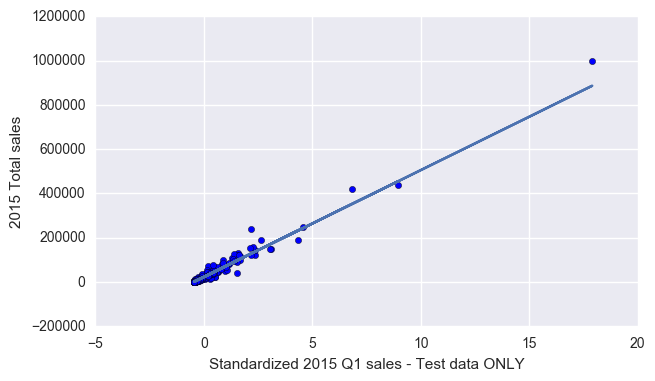

R2_test: 0.9671450873176126, RMSE_test: 11258.659754058655


In [55]:
# Predictions and scores on test set
Xs_test = (X_test - np.mean(X_train))/np.std(X_train)
ys_test = y_test
Xs_test = Xs_test.reshape(-1,1)

pred1 = lm1.predict(Xs_test)
pred1 = pred1.reshape(-1,1)

plt.figure(figsize=(7,4))
plt.xlabel("Standardized 2015 Q1 sales - Test data ONLY")
plt.ylabel("2015 Total sales")
plt.scatter(Xs_test, ys_test, label="Actual (test data ONLY)")
plt.plot(Xs_test, pred1, label="Predicted")
plt.show()

R2_test = metrics.r2_score(ys_test, pred1)
rmse_test = (metrics.mean_squared_error(ys_test, pred1))**0.5

print("R2_test: {}, RMSE_test: {}".format(R2_test, rmse_test))

#### 1.4: Model coefficients and intercepts

In [48]:
print("Intercept: {}, Coeff: {}".format(lm1.intercept_, lm1.coef_))

Intercept: 23187.35486131387, Coeff: [ 48231.05371408]


#### 1.5: Predicted 2016 sales

In [145]:
# Standardize "2016 Q1 sales" values
Xs_2016 = preprocessing.scale(sales_clean["2016 Sales Q1"])
Xs_2016 = Xs_2016.reshape(-1,1)
# Predict using lm1
Y1_2016 = lm1.predict(Xs_2016)

sales_clean["Projected 2016 Total sales ($)"] = Y1_2016

total_sales_by_county = pd.pivot_table(sales_clean, index="County number", 
                                       values=["2015 Total sales ($)", "Projected 2016 Total sales ($)"], 
                                      aggfunc=np.sum)
total_sales_by_county.head()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,2015 Total sales ($),Projected 2016 Total sales ($)
County number,,
1,42353.24,69269.290296
2,10245.14,12911.220713
3,79918.47,75088.580063
4,77033.64,186395.614638
5,2869.68,6651.125204


In [148]:
# Total 2015 vs 2016 sales
sum_2015 = np.sum(sales_clean["2015 Total sales ($)"])
sum_2016 = np.sum(sales_clean["Projected 2016 Total sales ($)"])
print("2015 Total across all stores: {}, 2016 Total across all stores: {}".format(int(sum_2015), int(sum_2016)))

2015 Total across all stores: 27036627, 2016 Total across all stores: 26503146


In [149]:
total_sales_by_county.shape

(99, 2)

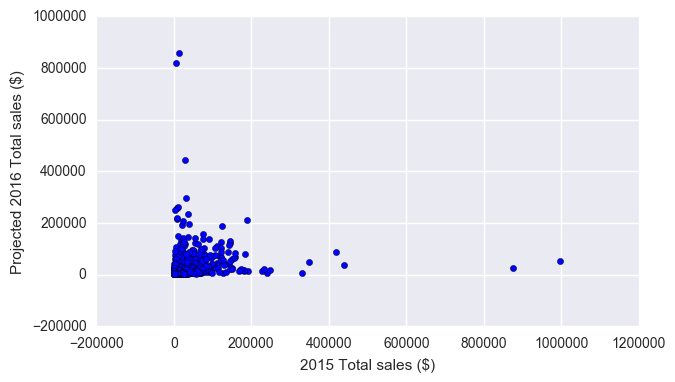

In [54]:
# Plot 2015vs 2016 sales for each store
plt.figure(figsize=(7,4))
plt.scatter(sales_clean["2015 Total sales ($)"], Y1_2016)
plt.xlabel("2015 Total sales ($)")
plt.ylabel("Projected 2016 Total sales ($)")
plt.show()

### Model 2: LR with CV, with various predictors

In [129]:
sales_clean["2015 Sales Q1 ^ 2"] = sales_clean["2015 Sales Q1"]**2
sales_clean["2015 Sales Q1 ^ 3"] = sales_clean["2015 Sales Q1"]**3
X = sales_clean[["2015 Sales Q1", "2015 Sales Q1 ^ 2", "2015 Sales Q1 ^ 3"]]
Y = sales_clean[["2015 Total sales ($)"]]
X.head()

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,2015 Sales Q1,2015 Sales Q1 ^ 2,2015 Sales Q1 ^ 3
0,39287.29,1.543491e+09,6.063958e+13
1,2833.25,8.027306e+06,2.274336e+10
2,24272.57,5.891577e+08,1.430037e+13
3,2003.46,4.013852e+06,8.041592e+09
4,5856.41,3.429754e+07,2.008604e+11


#### 2.1: Data preprocessing

In [134]:
# Split first
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4)

# Training set variables standardize
Xs_train = preprocessing.scale(X_train)
ys_train = y_train
Xs_train

C:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


array([[-0.17874672, -0.09357592, -0.05334412],
       [ 0.37510891, -0.04330224, -0.05060962],
       [ 0.0631181 , -0.07787813, -0.05276369],
       ..., 
       [-0.21852296, -0.09522871, -0.05338212],
       [-0.40475337, -0.09947739, -0.05344381],
       [-0.40785236, -0.09949944, -0.0534439 ]])

#### 2.2: Model building

In [135]:
lm2 = linear_model.LinearRegression()
model2 = lm2.fit(Xs_train, ys_train)
pred_model2 = lm2.predict(Xs_train)

#### 2.3: Model metrics

In [136]:
# Cross-validation
scores2 = cross_val_score(lm2, Xs_train, ys_train, cv = 6)
predcv2 = cross_val_predict(lm2, Xs_train, ys_train, cv = 6)

R2_model2 = metrics.r2_score(ys_train, pred_model2)
R2_cv_scores2 = np.mean(scores2)
rmse_model2 = (metrics.mean_squared_error(ys_train, pred_model2))**0.5
rmse_cv2 = (metrics.mean_squared_error(ys_train, predcv2))**0.5

print("R2_model_train: {}, R2_cv: {}".format(R2_model2, R2_cv_scores2))
print("rmse_model_train: {}, rmse_cv: {}".format(rmse_model2, rmse_cv2))

R2_model_train: 0.9665944979152435, R2_cv: 0.8879905293852893
rmse_model_train: 9374.473084259691, rmse_cv: 24567.509827238704


#### 2.4: Model coefficients

In [127]:
print("Intercept: {}, Coeff: {}".format(lm2.intercept_, lm2.coef_))

Intercept: [ 24265.97424818], Coeff: [[ 59309.91402729 -29650.74279731  27163.30995546]]


#### 2.5: Predictions on test set

In [137]:
# Predictions and scores on test set
Xs_test = (X_test - np.mean(X_train))/np.std(X_train)
ys_test = y_test

pred2 = lm2.predict(Xs_test)

#plt.figure(figsize=(7,4))
#plt.xlabel("Standardized 2015 Q1 sales - Test data ONLY")
#plt.ylabel("2015 Total sales")
#plt.scatter(Xs_test[:, 0], ys_test, label="Actual (test data ONLY)")
#plt.scatter(Xs_test[:, 0], pred2, label="Predicted", color="r")
#plt.show()

R2_test = metrics.r2_score(ys_test, pred2)
rmse_test = (metrics.mean_squared_error(ys_test, pred2))**0.5

print("R2_test: {}, RMSE_test: {}".format(R2_test, rmse_test))

R2_test: 0.9678902739267248, RMSE_test: 10643.792190983857
